# 3MD4120: Reinforcement Learning

## Individual Assignment

Author: Peter KESZTHELYI

Date: March, 2024

## Imports

In [1]:
#!pip3 install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git
import gym
import time
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pickle
import text_flappy_bird_gym
from collections import defaultdict
from tqdm import tqdm
from plot_utils import *

## Environment

In [2]:
# Initialize the environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

In [3]:
# Rendering environment
sys.stdout.write(env.render());

Text Flappy Bird!
Score: 0
----------------------
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[      @            |]
[                   |]
[                   |]
[                    ]
[                    ]
[                    ]
[                    ]
[                   |]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=13,dy=-5)


In [4]:
# Showing the state returned by environment
env.reset()

((13, -4), {'score': 0, 'player': [6, 7], 'distance': 13.601470508735444})

## Training

In [5]:
# Import Agents
from flappy_agents import FlappyESAgent, FlappyMonteCarloAgent

In [6]:
# Define training function
def train_agent(num_episodes, max_score, eps_start, eps_decay, eps_min, step_size, gamma, algorithm=None):
    """Train an agent using the specified algorithm.

    Args:
        num_episodes (int): Number of episodes to train the agent.
        max_score (int): Maximum score allowed before terminating an episode.
        eps_start (float): Initial value of epsilon for exploration.
        eps_decay (float): Decay rate of epsilon per episode.
        eps_min (float): Minimum value of epsilon.
        step_size (float): Step-size parameter for updating Q-values.
        gamma (float): Discount factor for future rewards.
        algorithm (str): Algorithm to use for training. Options: 'MC' for Monte Carlo, 'ES' for Expected SARSA.

    Returns:
        agent: Trained agent.
        scores_history (list): List of scores achieved in each episode.
        total_reward_history (list): List of cumulative rewards obtained in each episode.
    """
    assert algorithm in ['MC', 'ES'], "Invalid algorithm. Choose 'MC' for Monte Carlo or 'ES' for Expected SARSA."

    # Initialize environment
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

    # Get number of states and actions from environment
    n_states = env.observation_space[0].n * env.observation_space[1].n
    n_actions = env.action_space.n

    # Initialize agent parameters
    agent_info = {
        "num_actions": n_actions,
        "num_states": n_states,
        "eps_start": eps_start,
        "step_size": step_size,
        "eps_decay": eps_decay,
        "eps_min": eps_min,
        "discount": gamma,
        "seed": 0
    }

    # Initialize agent based on selected algorithm
    if algorithm == 'MC':
        agent = FlappyMonteCarloAgent()
    elif algorithm == 'ES':
        agent = FlappyESAgent()

    # Initialize agent with provided parameters
    agent.agent_init(agent_info)

    # Initialize lists to store scores and rewards per episode
    scores_history = []
    total_reward_history = []

    # Train the agent
    for _ in tqdm(range(num_episodes),leave=False):
        state = env.reset()  # Reset environment for each episode
        state = state[0]  # Extract tuple of (dx, dy) from the observation as the state

        action = agent.agent_start(state)
        reward = 0  # Initialize reward
        total_reward = 0  # Initialize cumulative reward

        # Run the episode until termination condition is met
        while True:
            action = agent.agent_step(reward, state)
            next_state, reward, done, _, info = env.step(action)  # Step in the environment

            total_reward += reward
            state = next_state

            # Check termination conditions
            if done or info['score'] >= max_score:
                agent.agent_end(reward)
                scores_history.append(info['score'])
                total_reward_history.append(total_reward)
                break

    return agent, scores_history, total_reward_history

### Sensitivity of algorithms to parameters

In [7]:
NUM_EPISODES = 1000
MOVING_AVG_WINDOW = 100

In [8]:
# Hyperparameter sensitivites generation
def generate_hyperparameter_sensitivity(algorithm, params, num_episodes=1000):
    """Generate hyperparameter sensitivity analysis results for the specified algorithm.

    This function performs sensitivity analysis by varying hyperparameters and recording the resulting scores and rewards.

    Args:
        algorithm (str): The algorithm to use for training. Options: 'MC' for Monte Carlo, 'ES' for Expected SARSA.
        params (dict): A dictionary containing lists of hyperparameters to vary.
                       Example: {'alpha': [0.1, 0.01], 'eps_start': [0.9, 0.5]}
        num_episodes (int): Number of episodes to train the agent for each hyperparameter combination. Default is 1000.

    Returns:
        dict: A dictionary containing the results of the sensitivity analysis.
              Example: {'scores': {(0.1, 0.9): [score1, score2, ...], (0.1, 0.5): [score1, score2, ...], ...},
                        'rewards': {(0.1, 0.9): [reward1, reward2, ...], (0.1, 0.5): [reward1, reward2, ...], ...}}
    """
    scores = {}
    rewards = {}
    i = 0
    for alpha in params['alpha']:
        for eps_start in params['eps_start']:
            i += 1
            _, scores_history, total_reward_history = train_agent(num_episodes=num_episodes,
                                                                   max_score=1500,
                                                                   eps_start=eps_start,
                                                                   eps_decay=0.99,
                                                                   eps_min=1e-4,
                                                                   step_size=alpha,
                                                                   gamma=0.95,
                                                                   algorithm=algorithm
                                                                   )
            scores[(alpha, eps_start)] = scores_history
            rewards[(alpha, eps_start)] = total_reward_history
    results = {"scores": scores, "rewards": rewards}
    return results


In [10]:
# Function to plot  scores or rewards of  agent based on the sleected hyperparameters
def plot_FB_HP_score(score_history, score_name, agent_name, window=100):
    """Plot scores or rewards of an agent based on the selected hyperparameters.

    This function plots the scores or rewards achieved by an agent over time, with variations in selected hyperparameters.

    Args:
        score_history (dict): Dictionary containing the scores or rewards achieved by the agent for different hyperparameter combinations.
                              Example: {'scores': {(0.1, 0.9): [score1, score2, ...], (0.1, 0.5): [score1, score2, ...], ...},
                                        'rewards': {(0.1, 0.9): [reward1, reward2, ...], (0.1, 0.5): [reward1, reward2, ...], ...}}
        score_name (str): Name of the score or reward to plot ('scores' or 'rewards').
        agent_name (str): Name of the agent for which the hyperparameters were tuned.
        window (int): Size of the moving average window for smoothing the plot. Default is 100.

    Returns:
        None
    """
    assert score_name in score_history.keys(), f"'{score_name}' not found in score_history keys."

    plt.figure(figsize=(16, 10))
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(score_history[score_name].keys())))))
    
    for pair in score_history[score_name].keys():
        plt.plot(pd.Series(score_history[score_name][pair]).rolling(window).mean(), 
                 label=f"step size: {pair[0]}, epsilon start: {pair[1]}")
            
    plt.title(f"{agent_name} Hyperparameter Tuning")
    plt.xlabel('Number of Episodes')
    plt.ylabel(f"Moving Average {score_name.capitalize()}")
    plt.legend()
    plt.show()


In [9]:
# Generate Hyperparameters sensitivites for ES
params = {"alpha": [0.25, 0.5, 0.75, 1.0], "eps_start": [0.5, 0.9]}
results = generate_hyperparameter_sensitivity('ES',params,NUM_EPISODES)

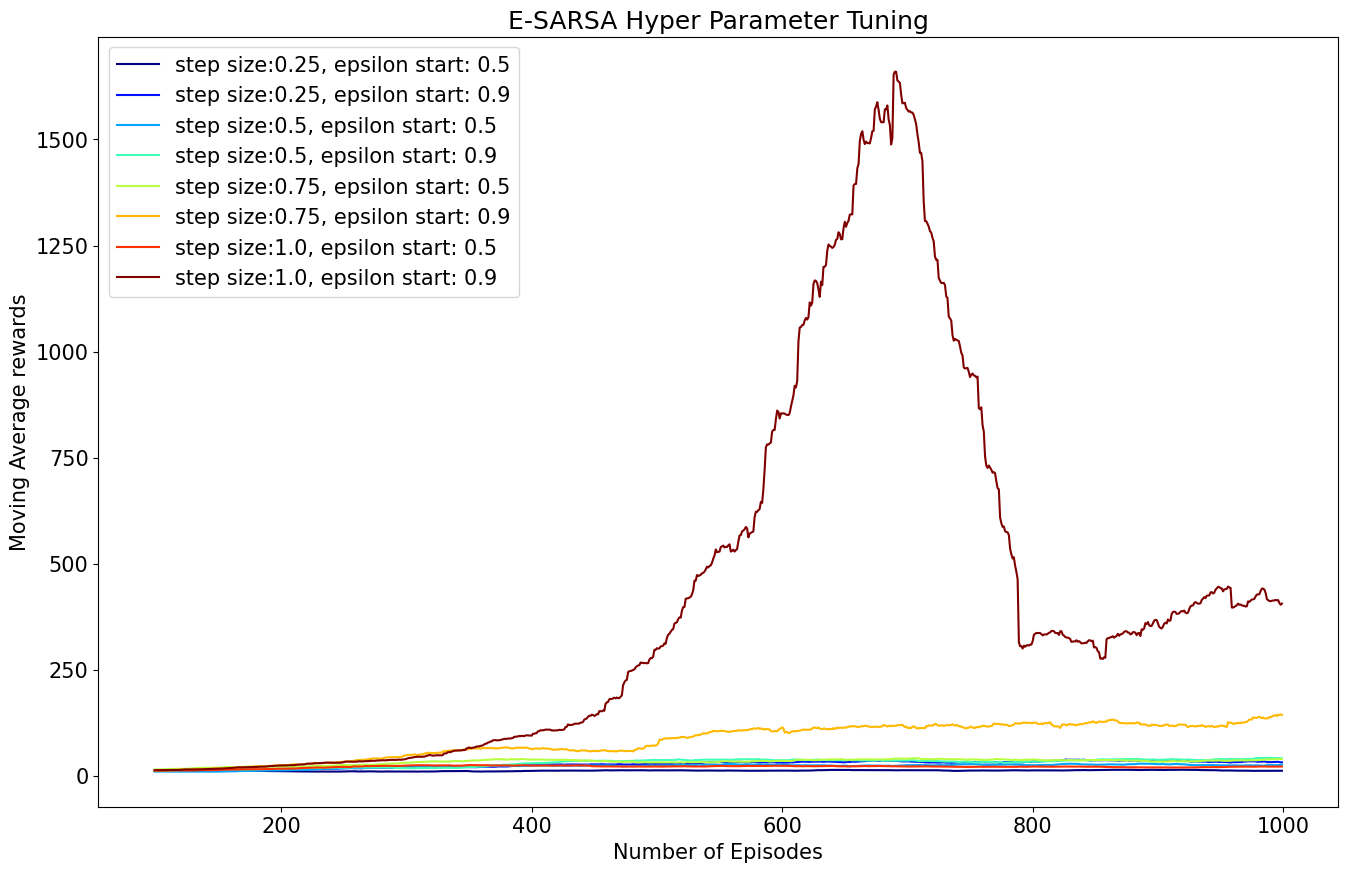

In [11]:
# Plot Hyperparam sensitivites for ES
plot_FB_HP_score(results,"rewards","E-SARSA",window = MOVING_AVG_WINDOW)

In [12]:
# Generate MC hyperparameter sensitivites
results = generate_hyperparameter_sensitivity('MC',params,NUM_EPISODES)

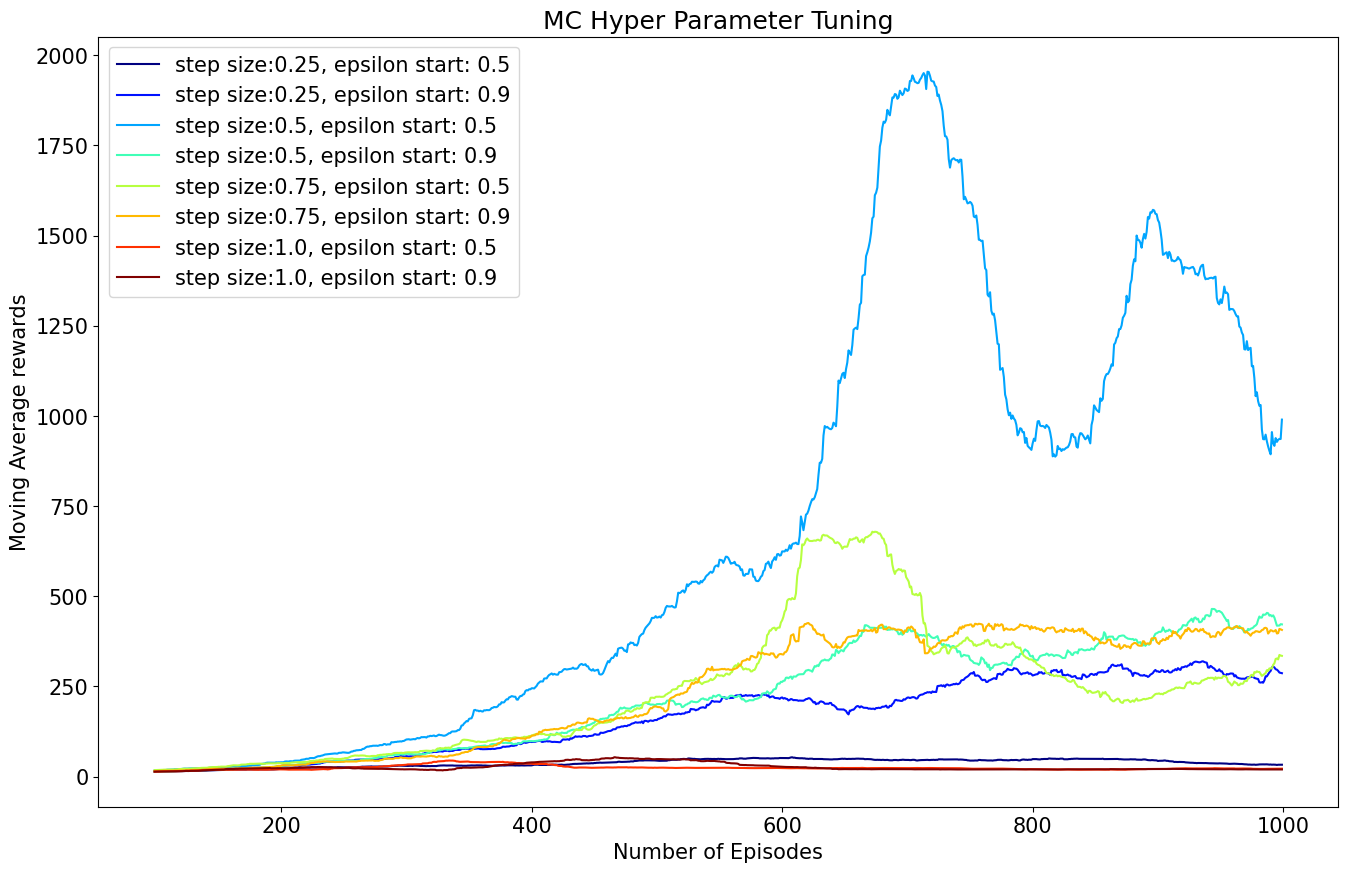

In [13]:
# Plot
plot_FB_HP_score(results,"rewards","MC",window = MOVING_AVG_WINDOW)

### Hyperparameter Tuning

In [47]:
def tune_hyperparameters(algorithm, num_episodes):
    """Tune hyperparameters for the specified algorithm using grid search.

    This function performs a grid search over a predefined range of hyperparameters to find the best combination
    that maximizes the average score achieved by the agent over the specified number of episodes.

    Args:
        algorithm (str): The algorithm to use for training. Options: 'MC' for Monte Carlo, 'ES' for Expected SARSA.
        num_episodes (int): Number of episodes to train the agent for each hyperparameter combination.

    Returns:
        tuple: A tuple containing the best agent, best hyperparameters, scores history, and total reward history.
               Example: (best_agent, best_hyperparameters, best_scores_history, best_total_reward_history)
    """
    from itertools import product

    # Define the range of hyperparameters to search over
    eps_start_values = [0.1, 0.9]
    eps_decay_values = [0.9, 0.99, 0.999]
    step_size_values = [0.1, 0.25, 0.5, 0.75, 1.0]
    gamma_values = [0.9, 0.95, 0.99]

    # Create a grid of all possible hyperparameter combinations
    hyperparameter_grid = product(eps_start_values, eps_decay_values, step_size_values, gamma_values)

    # Perform grid search
    best_score = float("-inf")
    best_hyperparameters = None
    best_agent = None
    for eps_start, eps_decay, step_size, gamma in hyperparameter_grid:
        esarsa_agent, scores_history, total_reward_history = train_agent(
            num_episodes=num_episodes,
            max_score=1500,
            eps_start=eps_start,
            eps_decay=eps_decay,
            eps_min=1e-4,
            step_size=step_size,
            gamma=gamma,
            algorithm=algorithm
        )
        average_score = sum(scores_history[-200:]) / len(scores_history[-200:])
        if average_score > best_score:
            best_score = average_score
            best_hyperparameters = (eps_start, eps_decay, step_size, gamma)
            best_agent = esarsa_agent
            best_scores_history = scores_history
            best_total_reward_history = total_reward_history
    
    print("Best hyperparameters:", best_hyperparameters)
    print("Best average score:", best_score)

    return best_agent, best_hyperparameters, best_scores_history, best_total_reward_history


In [48]:
# Get best parameters for MC
mc_best_agent, mc_best_hyperparameters, mc_best_scores_history, mc_best_total_reward_history = tune_hyperparameters('MC',NUM_EPISODES)

Best hyperparameters: (0.9, 0.99, 0.5, 0.9)
Best average score: 1057.13


In [49]:
# Get best parameters for ES
es_best_agent, es_best_hyperparameters, es_best_scores_history, es_best_total_reward_history = tune_hyperparameters('ES',NUM_EPISODES)

Best hyperparameters: (0.9, 0.99, 0.75, 0.95)
Best average score: 560.64


#### Saving the best agents

In [50]:
# Saving best agents
with open('./models/es_best_agent.pkl','wb') as file:
    pickle.dump(es_best_agent,file)

with open('./models/mc_best_agent.pkl','wb') as file:
    pickle.dump(mc_best_agent,file)

In [51]:
# Saving best agent results
np.save('./models/mc_best_scores_history.npy',np.array(mc_best_scores_history))
np.save('./models/mc_best_total_reward_history.npy',np.array(mc_best_total_reward_history))
np.save('./models/es_best_scores_history.npy',np.array(es_best_scores_history))
np.save('./models/es_best_total_reward_history.npy',np.array(es_best_total_reward_history))

## Evaluation and Comparison

In [7]:
# Loading best agents
with open('./models/es_best_agent.pkl','rb') as file:
    es_best_agent = pickle.load(file)

with open('./models/mc_best_agent.pkl','rb') as file:
    mc_best_agent = pickle.load(file)

In [8]:
# Loading best agent results
mc_best_scores_history          = np.load('./models/mc_best_scores_history.npy')
mc_best_total_reward_history    = np.load('./models/mc_best_total_reward_history.npy')
es_best_scores_history          = np.load('./models/es_best_scores_history.npy')
es_best_total_reward_history    = np.load('./models/es_best_total_reward_history.npy')

#### Visualising Policies

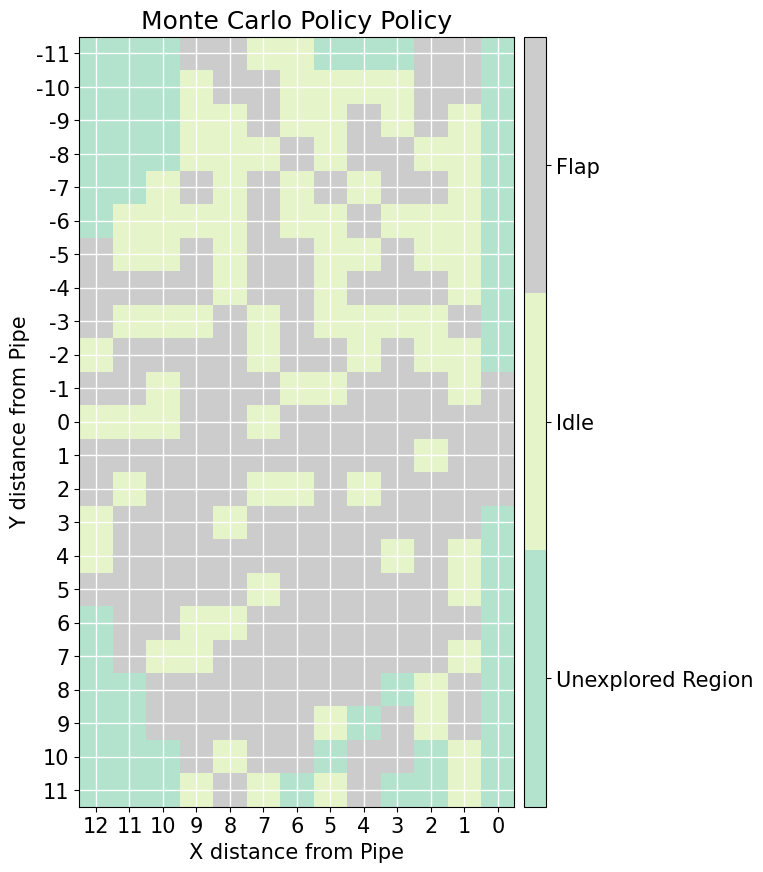

In [54]:
plot_policy(mc_best_agent,'Monte Carlo Policy')

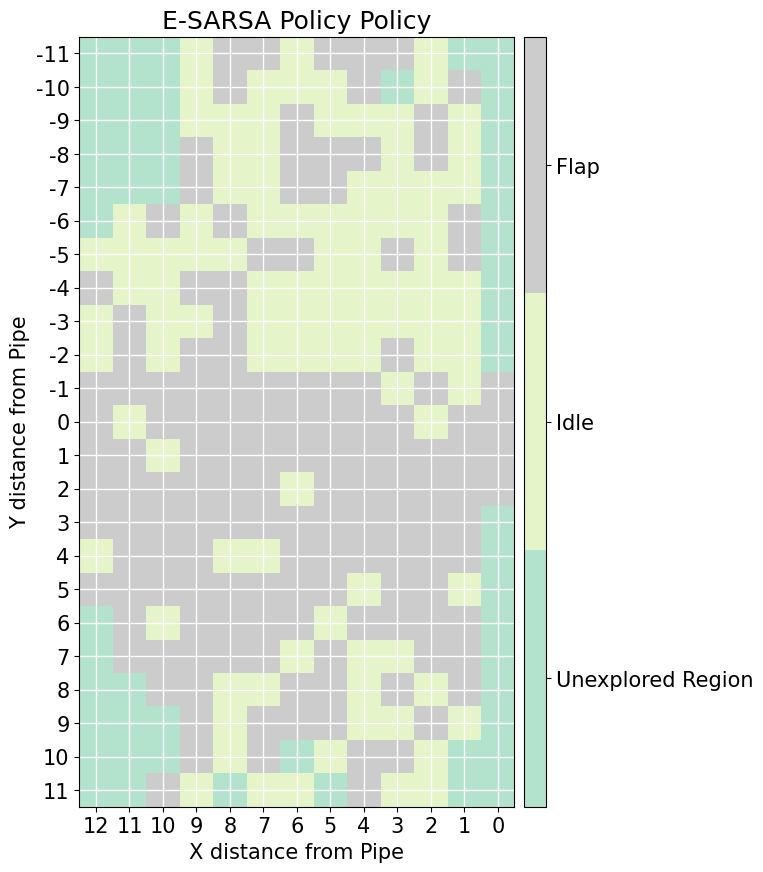

In [55]:
plot_policy(es_best_agent,'E-SARSA Policy')

#### State Value Function Plots

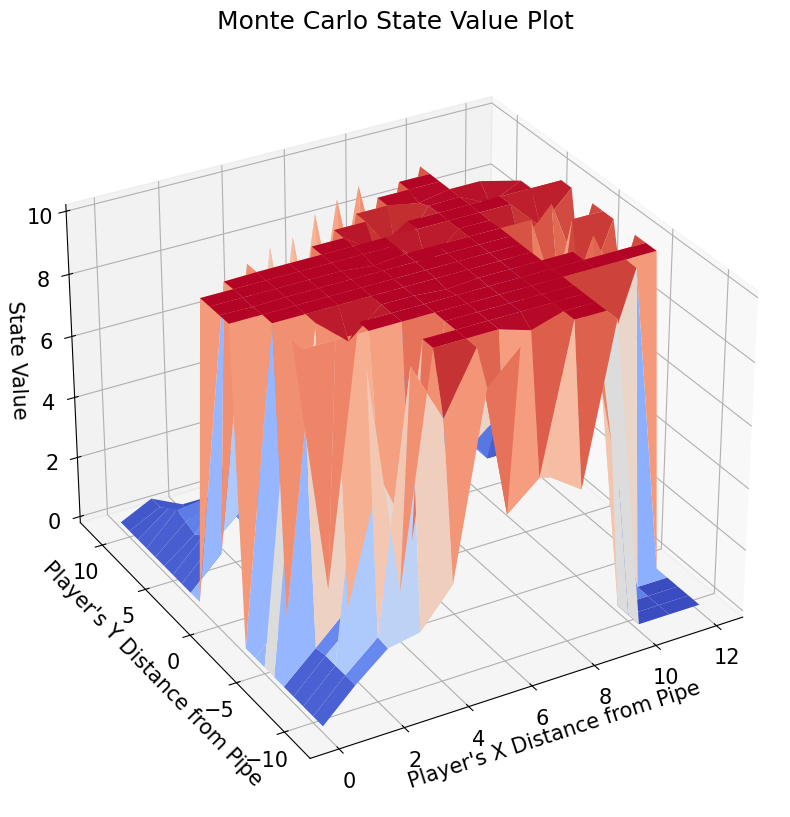

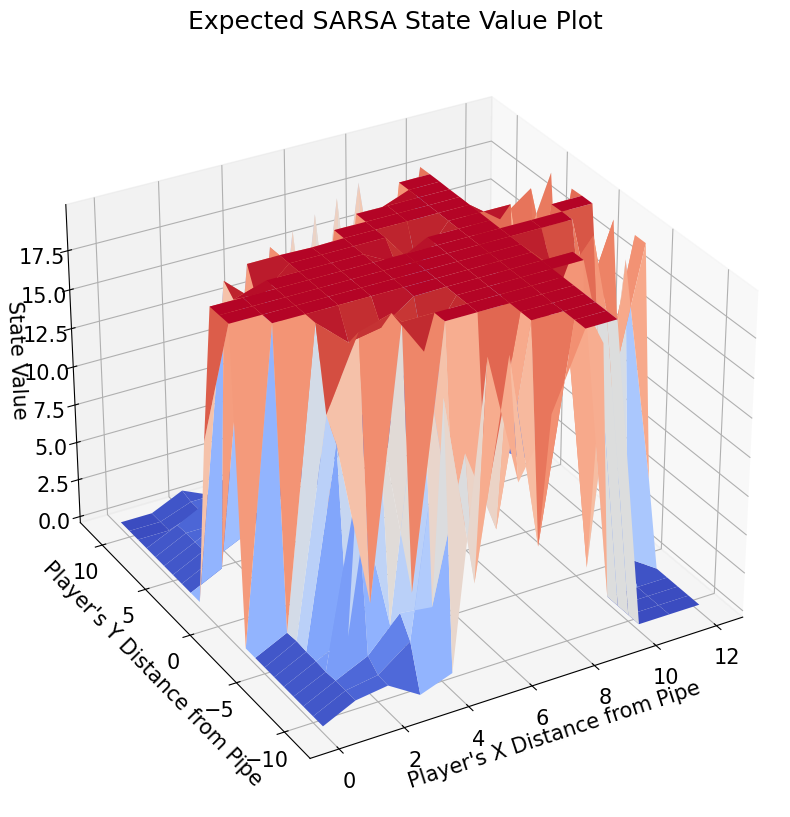

In [56]:
plot_FB_values(mc_best_agent, 'Monte Carlo')
plot_FB_values(es_best_agent, 'Expected SARSA')

#### Total Return Plots

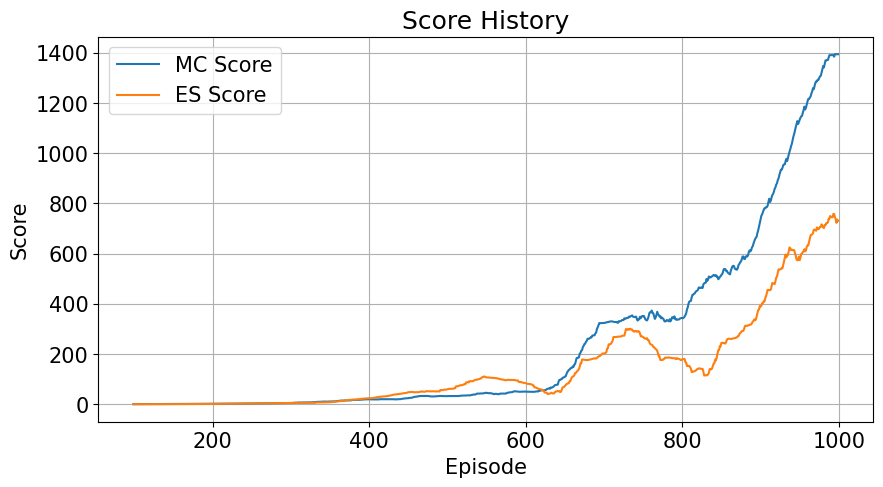

In [57]:
# Plot total reward history
plt.figure(figsize=(10, 5))
plt.plot(pd.Series(mc_best_scores_history).rolling(MOVING_AVG_WINDOW).mean(), label='MC Score')
plt.plot(pd.Series(es_best_scores_history).rolling(MOVING_AVG_WINDOW).mean(), label='ES Score')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Score History')
plt.legend()
plt.grid(True)
plt.show()


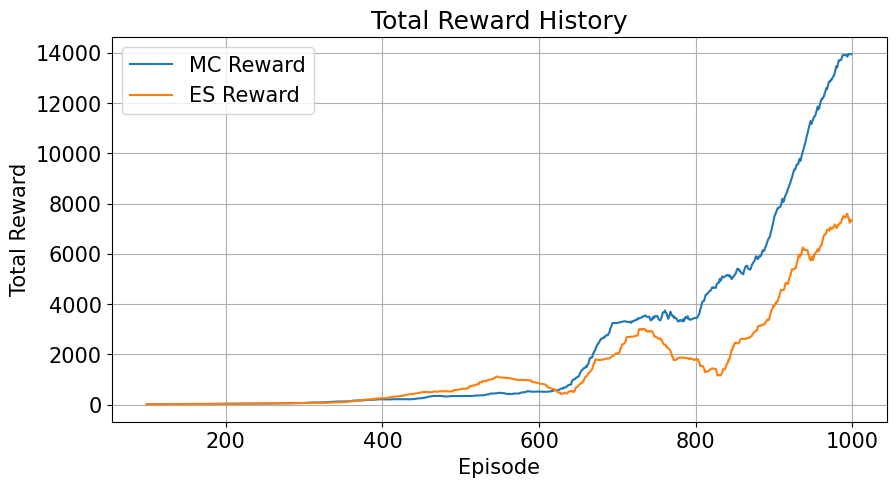

In [58]:
# Plot total reward history
plt.figure(figsize=(10, 5))
plt.plot(pd.Series(mc_best_total_reward_history).rolling(MOVING_AVG_WINDOW).mean(), label='MC Reward')
plt.plot(pd.Series(es_best_total_reward_history).rolling(MOVING_AVG_WINDOW).mean(), label='ES Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward History')
plt.legend()
plt.grid(True)
plt.show()


### Different Envirionment Configurations

In [9]:
def play_agent(agent, max_score=1500, num_games=100, width=20, height=15, pipe_gap=4):
    """Play the environment using the trained agent.

    Args:
        agent: Trained agent.
        max_score (int): Maximum score allowed before terminating an episode.

    Returns:
        scores_history (list): List of scores achieved in each episode.
        total_reward_history (list): List of cumulative rewards obtained in each episode.
    """
    # Initialize environment
    env = gym.make('TextFlappyBird-v0', height=height, width=width, pipe_gap=pipe_gap)

    # Initialize lists to store scores and rewards per episode
    scores_history = []
    total_reward_history = []

    # Play the agent in the environment
    for i in range(num_games):
        state = env.reset()  # Reset environment for each episode
        state = state[0]  # Extract tuple of (dx, dy) from the observation as the state
        done = False
        total_reward = 0  # Initialize cumulative reward

        # Run the episode until termination condition is met
        while not done:
            try:
                action = agent.agent_step(None, state)  # Get action from the agent
            except:
                action = 0
            
            next_state, reward, done, _, info = env.step(action)  # Step in the environment

            total_reward += reward
            state = next_state

            # Check termination conditions
            if done or info['score'] >= max_score:
                scores_history.append(info['score'])
                total_reward_history.append(total_reward)
                break

    return scores_history, total_reward_history

In [10]:
scores, rewards = play_agent(mc_best_agent, max_score=1500, num_games=40, width=15, height=10, pipe_gap=4)

In [16]:
# Define function to iterate over different configurations
def iterate_over_configurations(agent, max_score, num_games_per_config, configurations):
    """
    Iterate over different configurations of width and height parameters and save the average scores for each configuration.

    Args:
        agent: Trained agent.
        max_score (int): Maximum score allowed before terminating an episode.
        num_games_per_config (int): Number of games to play for each configuration.
        configurations (list of tuples): List of tuples containing different configurations of width and height parameters.

    Returns:
        average_scores (dict): Dictionary containing average scores for each configuration.
    """
    average_scores = {}

    for config in configurations:
        width, height, pipe_gap = config
        total_scores = []

        for _ in range(num_games_per_config):
            scores, _ = play_agent(agent, max_score, width=width, height=height, pipe_gap=pipe_gap)
            total_scores.extend(scores)

        average_score = np.mean(total_scores)
        average_scores[config] = average_score

    return average_scores

# Define different configurations to iterate over
configurations = [
    (20, 15, 4),
    (20, 15, 6),
    (20, 15, 3),
    (25, 18, 4),
    (30, 20, 6),
    (40, 30, 8),
    (80, 40, 10)
]


average_scores = iterate_over_configurations(mc_best_agent, max_score=1500, num_games_per_config=5, configurations=configurations)


In [17]:
# Showing average scores for different configurations
average_scores

{(20, 15, 4): 1296.938,
 (20, 15, 6): 1365.302,
 (20, 15, 3): 3.582,
 (25, 18, 4): 2.322,
 (30, 20, 6): 0.546,
 (40, 30, 8): 0.0,
 (80, 40, 10): 0.0}